In [7]:
import treecorr as tc
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt


In [2]:
quasar = np.load('../catalogue/quasar_narrow_z_cut.npy')
random = np.load('../catalogue/random_sample_quasar_narrow_z_cut.npy')

In [3]:
D = tc.Catalog(ra=quasar['ra'], dec=quasar['dec'], ra_units='deg', dec_units='deg', w=quasar['w'], npatch=100)
R = tc.Catalog(ra=random['ra'], dec=random['dec'], ra_units='deg', dec_units='deg', w=random['w'])

In [5]:
import astropy.units as u
from astropy.cosmology import Planck18 as cosmos
import astropy.coordinates as coo
z = 1.69
h = cosmos.H0.to(u.km/u.s/u.Mpc).value / 100
d_A = cosmos.angular_diameter_distance(z).to(u.Mpc).value
chi_l = d_A*(1+z)
Nbins = 15
r_bins = np.geomspace(3, 100, Nbins+1)        # unit: cMpc/h
theta_bins = r_bins/h/(1+z)/d_A

In [5]:
config = {'metric': 'Arc', 'max_sep': theta_bins[-1], 'min_sep': theta_bins[0], 'nbins':15, 'sep_units': 'rad', 'var_method':'jackknife'}
DD = tc.NNCorrelation(config=config)
DR = tc.NNCorrelation(config=config)
RR = tc.NNCorrelation(config=config)

DD.process(D)
DR.process(D, R)
RR.process(R)

In [6]:
xi, var_xi = DD.calculateXi(dr=DR, rr=RR)

In [68]:
cov = DD.cov

In [69]:
diag = [cov[i,i] for i in range(cov.shape[0])]
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        cov[i,j] /= np.sqrt(diag[i]*diag[j])

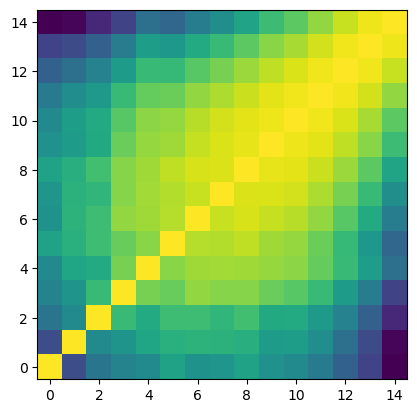

In [71]:
plt.imshow(cov, origin='lower')

Text(0.5, 0, "$\\theta[']$")

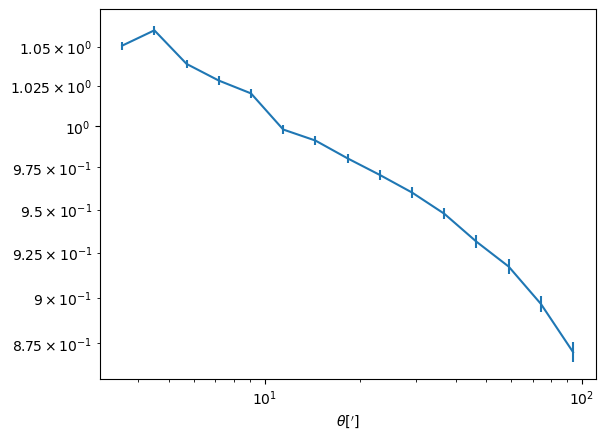

In [8]:
plt.errorbar((np.exp(DD.logr)*u.rad).to(u.arcmin), xi, var_xi)
plt.loglog()
plt.xlabel('$\\theta[\']$')

In [19]:
dd = np.load('../calculation_data/output_dd.npy')
dr = np.load('../calculation_data/output_dr.npy')
rr = np.load('../calculation_data/output_rr.npy')

In [20]:
Nd = dd.shape[0]
Nr = rr.shape[0]
dd_res = dd.sum(axis=0)/(Nd*(Nd-1)/2)
dr_res = dr.sum(axis=0)/(Nd*Nr)
rr_res = rr.sum(axis=0)/(Nr*(Nr-1)/2)

In [21]:
result = (dd_res - 2*dr_res + rr_res)/rr_res

In [22]:
theta = np.sqrt(theta_bins[1:]*theta_bins[:-1])

[]

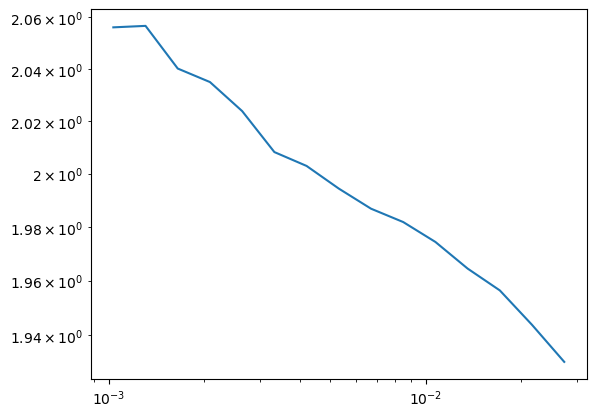

In [24]:
plt.plot(theta, result)
plt.loglog()

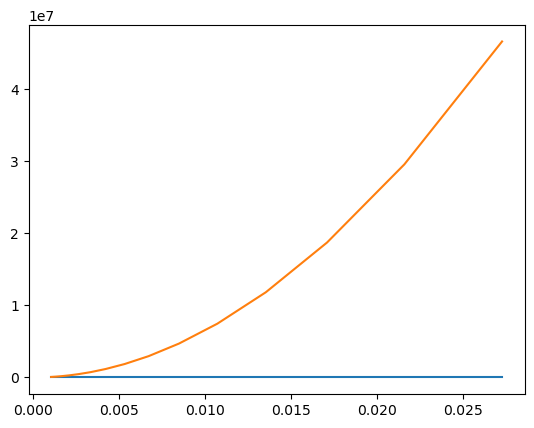

In [17]:
plt.plot(theta, dd_res)
plt.plot(theta, (dd[1:]-dd[:-1])/(Nd*(Nd-1)/2))

In [14]:
rand = np.load('../catalogue/random_sample_quasar_narrow_z_cut.npy')
quas = np.load('../catalogue/quasar_narrow_z_cut.npy')

from sklearn.neighbors import BallTree
tree_r = BallTree(np.deg2rad(np.c_[rand['dec'], rand['ra']]), leaf_size=5, metric='haversine')
tree_d = BallTree(np.deg2rad(np.c_[quas['dec'], quas['ra']]), leaf_size=5, metric='haversine')

In [22]:
dr = tree_r.two_point_correlation(np.deg2rad(np.c_[quas['dec'], quas['ra']]), theta_bins)

In [15]:
dd = tree_d.two_point_correlation(np.deg2rad(np.c_[quas['dec'], quas['ra']]), theta_bins)

In [27]:
rr = tree_r.two_point_correlation(np.deg2rad(np.c_[rand['dec'], rand['ra']]), theta_bins)

In [ ]:
np.save('dr_1', dr)
np.save('dd_1', dd)
np.save('rr_1', rr)